## Online system identification in Duffing oscillator by free energy minimisation

This project considers a [Duffing oscillator](hkps://en.wikipedia.org/wiki/Duffing_equation), a driven damped harmonic oscillator with a cubic nonlinearity in its spring stiffness component. State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

## Experiment: 1-step ahead prediction error

In this notebook, we will perform a forecasting experiment. At each point in time, we will make a prediction for the next observation. That prediction will be evaluated and compared to a few benchmark methods.

### Data

There is an electronic implementation of the Duffing oscillator on the Nonlinear System Identification Benchmark website: http://nonlinearbenchmark.org/#Silverbox. It's called Silverbox.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/syndr/Wouter/Onderzoek/Projecten/tueindhoven/control-nsi/IWAI2020-onlinesysid/Project.toml`


In [2]:
using CSV
using DataFrames

In [3]:
using Plots
pyplot();
viz = true;

In [4]:
# Read data from CSV file
df = CSV.read("data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Sampling frequency
fs = 610.35

# Shorthand
input = df[:,1]
output = df[:,2]

# T_valime horizon
T_val = size(df, 1);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = ip:0x0
└ @ Core :-1


In [5]:
# Select training set
ix_trn = collect(40101:131072)
input_trn = input[ix_trn]
output_trn = output[ix_trn]
T_trn = length(ix_trn);

# Select validation set
ix_val = 1:40100 
input_val = input[ix_val]
output_val = output[ix_val]
T_val = length(ix_val);

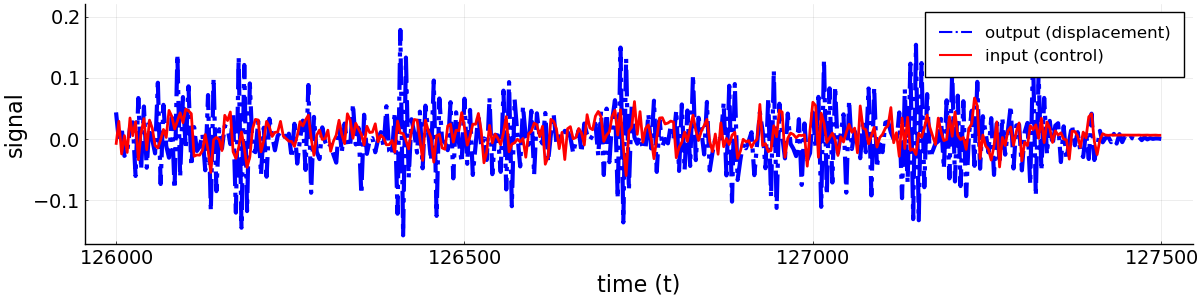

In [6]:
# Plot example of signals
ss = 4
ix = 126000:ss:127500
p31 = Plots.plot(ix, output[ix], color="blue", linewidth=3, xlabel="time (t)", label="output (displacement)", linestyle=:dashdot)    
Plots.plot!(ix, input[ix], color="red", linewidth=2, xlabel="time (t)", label="input (control)", size=(1200,300), ylim=[-.16, .21], legend=:topright, tickfontsize=14, legendfontsize=12, ylabel="signal", guidefontsize=16)

In [7]:
Plots.savefig(p31, "figures/input-output_seq1.png")
Plots.savefig(p31, "figures/input-output_seq1.pdf")

## Solution steps

### 1. Discretize

I'm using a central difference for the second derivative and a forward difference for the first derivative. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The state transition can now be wriken as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + c (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$
Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
% (m + c) x_{t+1}&\ + (-2m - c + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
x_{t+1}&\ = \frac{2m + c - a}{m + c} x_{t} + \frac{-b}{m + c}x_t^3 + \frac{-m}{m + c} x_{t-1} + \frac{1}{m + c} u_t + \frac{1}{m + c} w_t \, .
\end{align}$$

### 2. Substitute variables and reduce order

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{s} g(\theta, z_{t-1}) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where

$$\begin{align}
\theta_1 = \frac{2m+c-a}{m+c} \ , \quad
\theta_2 = \frac{-b}{m+c} \ , \quad
\theta_3 = \frac{-m}{m+c} \ , \quad
\eta = \frac{1}{m+c} \ , \quad
\gamma^{-1} = \frac{\tau^{-1}}{(m+c)^2} \, ,
\end{align}$$

with $g(\theta, z_{t-1}) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,c,a,b,\tau$ and five equations. I can invert the mapping between $\phi = (m, c, a, b, \tau)$ and $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$ to recover MAP estimates for the physical parameters. An additional advantage of variable substitution is that it allows for more freedom in choosing priors.

The system is now a nonlinear autoregressive process:

$$z_t = f(\theta, z_{t-1}, \eta, u_t) + \tilde{w}_t$$

where $f(\theta, z_{t-1}, \eta, u_t) = Sz_{t-1} + s g(\theta, z_{t-1}) + s \eta u_t$. Note that the states are two-dimensional now.

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_t \sim&\ \mathcal{N}(f(\theta, z_{t-1}, \eta, u_t), V) \\
y_t \sim&\ \mathcal{N}(s^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W = V^{-1} = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### 4. Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion. The work here revolves around working out the expectations for $g(x,\theta)$:

$$ g(\theta, x) = g(m_{\theta}, m_x) + J_{x}(m_{\theta}, m_x)^{\top}(x - m_x) + J_{\theta}(m_{\theta}, m_x)^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and one could argue that the approximation is unnecessary. However, this form is more general and the first-order T_valaylor is exact anyway.

### 5. Choose priors

We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. By examing the nonlinear transform $\psi = G(\phi)$, we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \ , \quad 
\eta \sim \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \ , \quad  
\gamma \sim \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

### 6. Choose recognition model

We do not introduce any independencies; the recognition model follows the generative model:

$$\begin{align}
q(\theta) \sim \text{Normal}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) \sim \text{Normal}(m_{\eta}, v_{\eta}) \ , \quad  
q(\gamma) \sim \text{Gamma}(a_\gamma, b_\gamma) \, .
\end{align}$$

## Implementation

The procedure described above was implemented using [ForneyLab.jl](hkps://github.com/biaslab/ForneyLab.jl) with a custom node called "NLARX". It contains a Nonlinear Latent Autoregressive model with eXogenous input to model the state transition.

In [8]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

include("NLARX-node/NLARX.jl")
include("NLARX-node/util.jl")
using .NLARX

In [9]:
# System identification graph
graph1 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
g(θ, x) = θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12671518859741634032 -->
 
 12671518859741634032 
 
 𝒩 
 y_t 
 
<!-- 10604574948593785502 -->
 
 10604574948593785502 
 
 dot 
 dotproduct_1 
 
<!-- 12671518859741634032--10604574948593785502 -->
 
 12671518859741634032--10604574948593785502 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 9647166458439993240 -->
 
 9647166458439993240 
 
 Gam 
 gamma_2 
 
<!-- 12671518859741634032--9647166458439993240 -->
 
 12671518859741634032--9647166458439993240 
 
 ξ 
 1 out 
 3 w 
 
<!-- 3410248966036221585 -->
 
 3410248966036221585 
 
 placeholder_y_t 
 
<!-- 3410248966036221585--12671518859741634032 -->
 
 3410248966036221585--12671518859741634032 
 
 y_t 
 1 out 
 1 out 
 
<!-- 12584510922141715208 -->
 
 12584510922141715208 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 13548489459728893837 -->
 
 13548489459728893837 
 
 placeholder_w_θ 
 
<!-- 12584510922141715208--13548489459728893837 -->
 
 12584510922141715208--13548489459728893837 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 15871091390692778607 -->
 
 15871091390692778607 
 
 placeholder_m_θ 
 
<!-- 12584510922141715208--15871091390692778607 -->
 
 12584510922141715208--15871091390692778607 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 15533622986188662626 -->
 
 15533622986188662626 
 
 placeholder_b_γ 
 
<!-- 7908112032059288795 -->
 
 7908112032059288795 
 
 NLARX 
 z_t 
 
<!-- 10604574948593785502--7908112032059288795 -->
 
 10604574948593785502--7908112032059288795 
 
 z_t 
 1 y 
 2 in1 
 
<!-- 9605588552933951915 -->
 
 9605588552933951915 
 
 clamp_1 
 
<!-- 10604574948593785502--9605588552933951915 -->
 
 10604574948593785502--9605588552933951915 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 12221148333987435728 -->
 
 12221148333987435728 
 
 placeholder_a_γ 
 
<!-- 5205679909377273505 -->
 
 5205679909377273505 
 
 𝒩 
 z_tmin1 
 
<!-- 17946579029715575184 -->
 
 17946579029715575184 
 
 placeholder_w_z 
 
<!-- 5205679909377273505--17946579029715575184 -->
 
 5205679909377273505--17946579029715575184 
 
 w_z 
 1 out 
 3 w 
 
<!-- 4549836975050737752 -->
 
 4549836975050737752 
 
 placeholder_m_z 
 
<!-- 5205679909377273505--4549836975050737752 -->
 
 5205679909377273505--4549836975050737752 
 
 m_z 
 1 out 
 2 m 
 
<!-- 7908112032059288795--12584510922141715208 -->
 
 7908112032059288795--12584510922141715208 
 
 θ 
 1 out 
 3 θ 
 
<!-- 7908112032059288795--5205679909377273505 -->
 
 7908112032059288795--5205679909377273505 
 
 z_tmin1 
 1 out 
 2 x 
 
<!-- 12144754667467025424 -->
 
 12144754667467025424 
 
 placeholder_u_t 
 
<!-- 7908112032059288795--12144754667467025424 -->
 
 7908112032059288795--12144754667467025424 
 
 u_t 
 1 out 
 5 u 
 
<!-- 4485549227008197465 -->
 
 4485549227008197465 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 7908112032059288795--4485549227008197465 -->
 
 7908112032059288795--4485549227008197465 
 
 η 
 1 out 
 4 η 
 
<!-- 15516664999078760017 -->
 
 15516664999078760017 
 
 Gam 
 gamma_1 
 
<!-- 7908112032059288795--15516664999078760017 -->
 
 7908112032059288795--15516664999078760017 
 
 γ 
 1 out 
 6 γ 
 
<!-- 15404333288571513331 -->
 
 15404333288571513331 
 
 placeholder_w_η 
 
<!-- 4485549227008197465--15404333288571513331 -->
 
 4485549227008197465--15404333288571513331 
 
 w_η 
 1 out 
 3 w 
 
<!-- 16061961574386885201 -->
 
 16061961574386885201 
 
 placeholder_m_η 
 
<!-- 4485549227008197465--16061961574386885201 -->
 
 4485549227008197465--16061961574386885201 
 
 m_η 
 1 out 
 2 m 
 
<!-- 6981806523300623822 -->
 
 6981806523300623822 
 
 placeholder_b_ξ 
 
<!-- 9647166458439993240--6981806523300623822 -->
 
 9647166458439993240--6981806523300623822 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 14543978126611502672 -->
 
 14543978126611502672 
 
 placeholder_a_ξ 
 
<!-- 9647166458439993240--14543978126611502672 -->
 
 9647166458439993240--1454

In [10]:
# Specify recognition model
q1 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=true)

# Compile inference algorithm
source_code1 = algorithmSourceCode(algo1, free_energy=true)
eval(Meta.parse(source_code1));
# println(source_code1)

### Infer parameters on training data

In [11]:
# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize free energy tracking array
free_energy_trn = zeros(T_trn, num_iterations)

# Initialize arrays of parameterizations
params_z = (zeros(2,T_trn+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_trn+1)))
params_θ = (ones(3,T_trn+1), repeat(.1 .*float(eye(3)), outer=(1,1,T_trn+1)))
params_η = (2*ones(1,T_trn+1), 1e2 *ones(1,T_trn+1))
params_γ = (1e8*ones(1,T_trn+1), 1e3*ones(1,T_trn+1))
params_ξ = (1e8*ones(1,T_trn+1), 1e1*ones(1,T_trn+1))

# Start progress bar
p = Progress(T_trn, 1, "At time ")

# Perform inference at each time-step
for t = 1:T_trn

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output_trn[t],
                :u_t => input_trn[t],
                :m_z => params_z[1][:,t],
                :w_z => params_z[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        # Update parameters
        stepη!(data, marginals)
        stepθ!(data, marginals)
        
        # Update states
        stepz_t!(data, marginals)
        stepz_tmin1!(data, marginals)
        
        # Update noise
        stepγ!(data, marginals)
        stepξ!(data, marginals)
        
        # Compute free energy
        free_energy_trn[t, i] = freeEnergy(data, marginals)
        
    end

    # Store current parameterizations of marginals
    params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:04:4939m


### K-step ahead prediction on validation data

In [12]:
# Prediction graph
graph2 = FactorGraph()

# Autoregressive node
@RV z_pred ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), placeholder(:z_tmin1, dims=(2,)), placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_pred_t)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred, ids=[:z_pred])
algo2 = variationalAlgorithm(q2, free_energy=true)
source_code2 = algorithmSourceCode(algo2, free_energy=true)
eval(Meta.parse(source_code2));
# println(source_code2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15381291641375664853 -->
 
 15381291641375664853 
 
 placeholder_u_t 
 
<!-- 18009535757721632067 -->
 
 18009535757721632067 
 
 NLARX 
 z_pred_t 
 
<!-- 18009535757721632067--15381291641375664853 -->
 
 18009535757721632067--15381291641375664853 
 
 u_t 
 1 out 
 5 u 
 
<!-- 1503102225259389867 -->
 
 1503102225259389867 
 
 placeholder_θ 
 
<!-- 18009535757721632067--1503102225259389867 -->
 
 18009535757721632067--1503102225259389867 
 
 θ 
 1 out 
 3 θ 
 
<!-- 15917477270118427575 -->
 
 15917477270118427575 
 
 placeholder_z_tmin1 
 
<!-- 18009535757721632067--15917477270118427575 -->
 
 18009535757721632067--15917477270118427575 
 
 z_tmin1 
 1 out 
 2 x 
 
<!-- 3039113976350850172 -->
 
 3039113976350850172 
 
 placeholder_γ 
 
<!-- 18009535757721632067--3039113976350850172 -->
 
 18009535757721632067--3039113976350850172 
 
 γ 
 1 out 
 6 γ 
 
<!-- 12195942280971443230 -->
 
 12195942280971443230 
 
 placeholder_η 
 
<!-- 18009535757721632067--12195942280971443230 -->
 
 18009535757721632067--12195942280971443230 
 
 η 
 1 out 
 4 η 
 
<!-- 140867179506438458022 -->
 
 140867179506438458022 
 
<!-- 140867179506438458022--18009535757721632067 -->
 
 140867179506438458022--18009535757721632067 
 
 z_pred 
 1 y

In [13]:
# Number of steps ahead
K = 1

# Initialize free energy tracking array
free_energy_pred = zeros(T_val, num_iterations)

# Initialize future state arrays
params_preds = (zeros(2, T_val - K, K+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_val - K, K+1)))

# Start progress bar
p = Progress(T_val - K, 1, "At time ")

for t = 3:(T_val - K)
    update!(p, t)

    for k = 1:K

        # Initialize marginals
        marginals[:z_pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,t,k], w=params_preds[2][:,:,t,k])

        # Clamp data
        data = Dict(:u_t => input[t+k],
                    :z_tmin1 => output_val[t+k-1:-1:t+k-2],
                    :θ => params_θ[1][:,end],
                    :η => params_η[1][end],
                    :γ => params_γ[1][end]/params_γ[2][end])

        # Iterate variational parameter updates
        for i = 1:num_iterations
            
            # Make prediction
            stepz_pred!(data, marginals)
            
            # Compute free energy
            free_energy_pred[t, i] = freeEnergy(data, marginals)
        end

        # Store current parameterizations of marginals
        params_preds[1][:,t,k+1] = unsafeMean(marginals[:z_pred])
        params_preds[2][:,:,t,k+1] = marginals[:z_pred].params[:w]

    end
end

At time 100%|███████████████████████████████████████████| Time: 0:00:13


In [14]:
# Store predictions for later comparisons
results_NLARX = Dict()
results_NLARX["preds"] = params_preds
results_NLARX["params_z"] = params_z;
results_NLARX["params_θ"] = params_θ;
results_NLARX["params_η"] = params_η;
results_NLARX["params_γ"] = params_γ;
results_NLARX["params_ξ"] = params_ξ;
results_NLARX["FE_pred"] = free_energy_pred;
results_NLARX["FE_trn"] = free_energy_trn;

### Visualize results

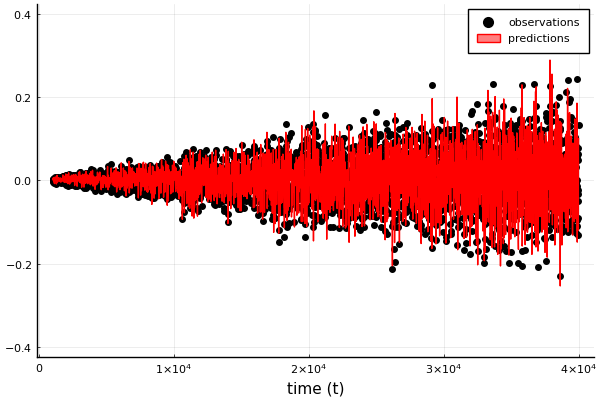

In [15]:
# Mean and std dev of predictions
predictions_mean = params_preds[1][1,:,K+1]
predictions_std = sqrt.(inv.(params_preds[2][1,1,:,K+1])) 

# Subsample for visualization
ss = 10
# viz_ix = 50000:ss:60000
viz_ix = 1024:ss:40000

# Plot predictions
p23 = scatter(viz_ix, output[viz_ix], label="observations", xlabel="time (t)", ylims=[-.4, .4], color="black")
plot!(viz_ix, predictions_mean[viz_ix], ribbon=[predictions_std[viz_ix], predictions_std[viz_ix]], label="predictions", color="red")

In [16]:
Plots.savefig(p23, "figures/predictions_nlarx.png")

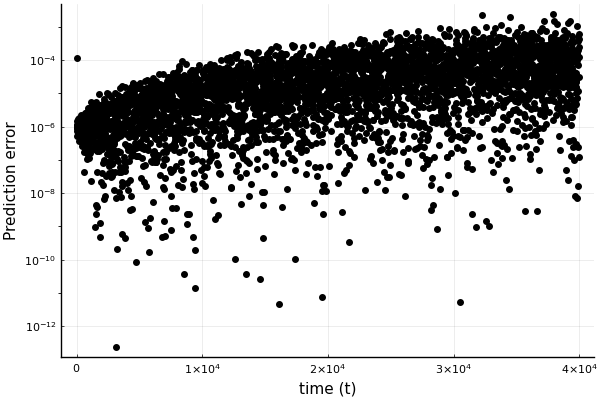

In [17]:
# Compute prediction error
pred_error = (predictions_mean[2:end] .- output_val[3:end]).^2

# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Scatter error over time
p24 = scatter(viz_ix, pred_error[viz_ix], color="black", xlabel="time (t)", ylabel="Prediction error", label="", yscale=:log10)

In [18]:
Plots.savefig(p24, "figures/pred-error_nlarx.png")

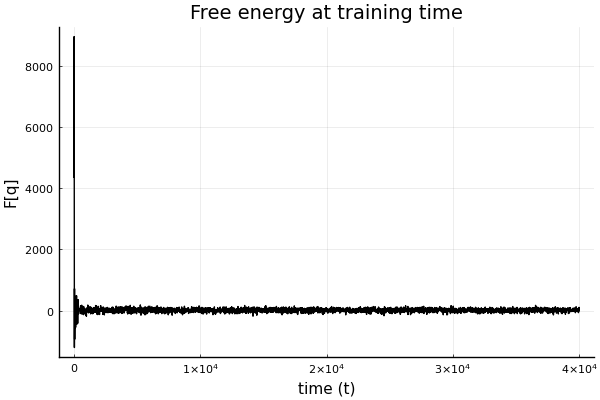

In [19]:
# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Scatter error over time
p24 = plot(viz_ix, free_energy_trn[viz_ix,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy at training time")

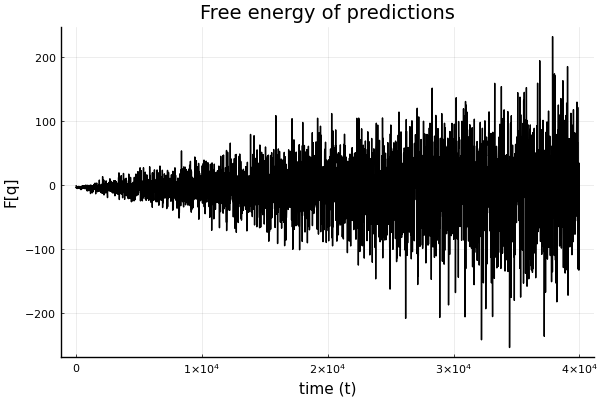

In [20]:
# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Scatter error over time
p24 = plot(viz_ix, free_energy_pred[viz_ix,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy of predictions")

## Baseline: linear autoregression

In [21]:
# System identification graph
graph3 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Linear autoregression function
g(θ, x) = θ[1]*x[1] + θ[2]*x[2]

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Specify recognition model
q3 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo3 = variationalAlgorithm(q3, free_energy=true)

# Compile inference algorithm
source_code3 = algorithmSourceCode(algo3, free_energy=true)
eval(Meta.parse(source_code3));
# println(source_code3)

In [22]:
# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize free energy tracking array
free_energy_trn = zeros(T_trn, num_iterations)

# Initialize arrays of parameterizations
params_z = (zeros(2,T_trn+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_trn+1)))
params_θ = (ones(2,T_trn+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_trn+1)))
params_η = (2*ones(1,T_trn+1), 1e2 *ones(1,T_trn+1))
params_γ = (1e8*ones(1,T_trn+1), 1e3*ones(1,T_trn+1))
params_ξ = (1e8*ones(1,T_trn+1), 1e1*ones(1,T_trn+1))

# Start progress bar
p = Progress(T_trn, 1, "At time ")

# Perform inference at each time-step
for t = 1:T_trn

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output_trn[t],
                :u_t => input_trn[t],
                :m_z => params_z[1][:,t],
                :w_z => params_z[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        # Update parameters
        stepη!(data, marginals)
        stepθ!(data, marginals)
        
        # Update states
        stepz_t!(data, marginals)
        stepz_tmin1!(data, marginals)
        
        # Update noise
        stepγ!(data, marginals)
        stepξ!(data, marginals)
        
        # Compute free energy
        free_energy_trn[t, i] = freeEnergy(data, marginals)
        
    end

    # Store current parameterizations of marginals
    params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:03:31


In [23]:
# Prediction graph
graph4 = FactorGraph()

# Autoregressive node
@RV z_pred ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), placeholder(:z_tmin1, dims=(2,)), placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_pred_t)

# Inference algorithm
q4 = PosteriorFactorization(z_pred, ids=[:z_pred])
algo4 = variationalAlgorithm(q4, free_energy=true)
source_code4 = algorithmSourceCode(algo4, free_energy=true)
eval(Meta.parse(source_code4));

In [24]:
# Number of steps ahead
K = 1

# Initialize free energy tracking array
free_energy_pred = zeros(T_val, num_iterations)

# Initialize future state arrays
params_preds = (zeros(2, T_val - K, K+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_val - K, K+1)))

# Start progress bar
p = Progress(T_val - K, 1, "At time ")

for t = 3:(T_val - K)
    update!(p, t)

    for k = 1:K

        # Initialize marginals
        marginals[:z_pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,t,k], w=params_preds[2][:,:,t,k])

        # Clamp data
        data = Dict(:u_t => input[t+k],
                    :z_tmin1 => output_val[t+k-1:-1:t+k-2],
                    :θ => params_θ[1][:,end],
                    :η => params_η[1][end],
                    :γ => params_γ[1][end]/params_γ[2][end])

        # Iterate variational parameter updates
        for i = 1:num_iterations
            
            # Make prediction
            stepz_pred!(data, marginals)
            
            # Compute free energy
            free_energy_pred[t, i] = freeEnergy(data, marginals)
        end

        # Store current parameterizations of marginals
        params_preds[1][:,t,k+1] = unsafeMean(marginals[:z_pred])
        params_preds[2][:,:,t,k+1] = marginals[:z_pred].params[:w]

    end
end

At time 100%|███████████████████████████████████████████| Time: 0:00:11


In [25]:
# Store predictions for later comparisons
results_LARX = Dict()
results_LARX["preds"] = params_preds
results_LARX["params_z"] = params_z;
results_LARX["params_θ"] = params_θ;
results_LARX["params_η"] = params_η;
results_LARX["params_γ"] = params_γ;
results_LARX["params_ξ"] = params_ξ;
results_LARX["FE_pred"] = free_energy_pred;
results_LARX["FE_trn"] = free_energy_trn;

### Visualize results

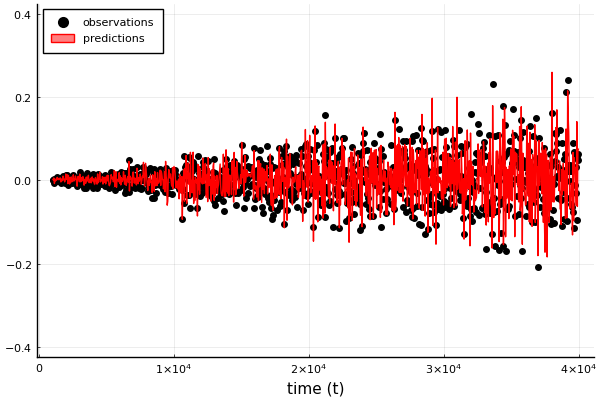

In [26]:
# Mean and std dev of predictions
predictions_mean = params_preds[1][1,:,K+1]
predictions_std = sqrt.(inv.(params_preds[2][1,1,:,K+1])) 

# Subsample for visualization
ss = 40
# viz_ix = 50000:ss:60000
viz_ix = 1024:ss:40000

# Plot predictions
p230 = scatter(viz_ix, output[viz_ix], color="black", label="observations", xlabel="time (t)", ylims=[-.4, .4], legend=:topleft)
plot!(viz_ix, predictions_mean[viz_ix], ribbon=[predictions_std[viz_ix], predictions_std[viz_ix]], color="red",  label="predictions")

In [27]:
Plots.savefig(p230, "figures/predictions_larx.png")

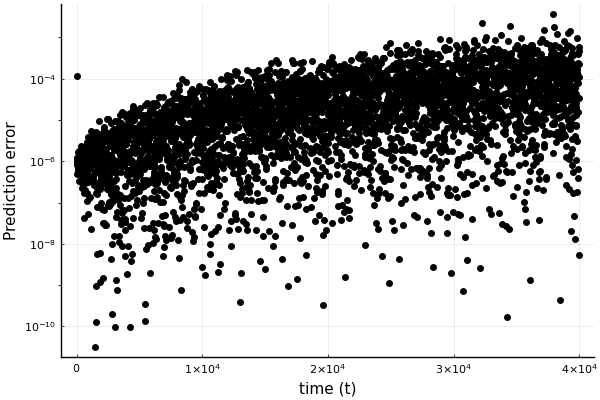

In [28]:
# Compute prediction error
pred_error = (predictions_mean[2:end] .- output_val[3:end]).^2

# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Scatter error over time
p240 = scatter(viz_ix, pred_error[viz_ix], color="black", xlabel="time (t)", ylabel="Prediction error", label="", yscale=:log10)

In [29]:
Plots.savefig(p240, "figures/pred-error_larx.png")

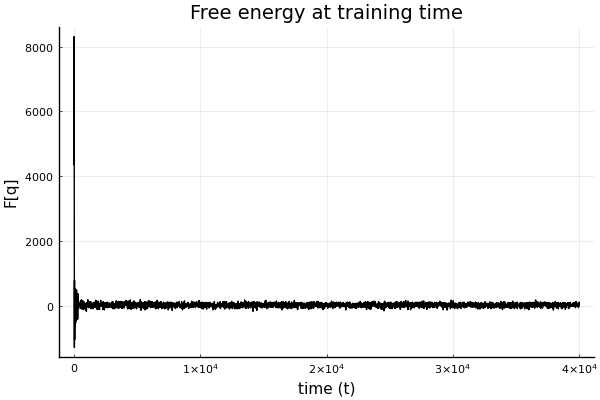

In [30]:
# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Scatter error over time
p24 = plot(viz_ix, free_energy_trn[viz_ix,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy at training time")

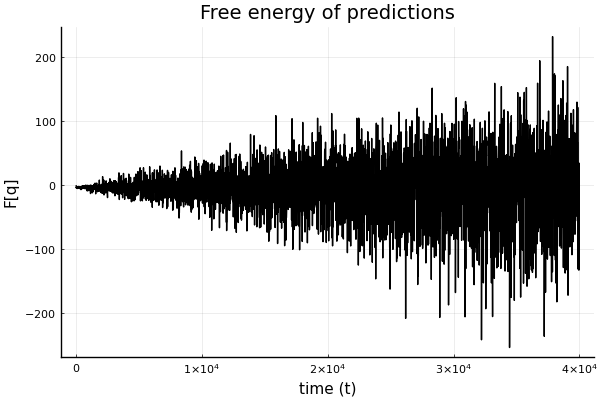

In [31]:
# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Scatter error over time
p24 = plot(viz_ix, free_energy_pred[viz_ix,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy of predictions")

### Baseline: offline sigmoid network NARX model

As baseline, I ran a nonlinear ARX model using Matlab's System Identification Toolbox. Parameters are estimated using a Prediction Error Minimisation (PEM) procedure. It simultaneously estimates a static nonlinearity that I'm modelling with a sigmoid network. I've used 4 units to keep the comparison with the 4-coefficient NLARX model fair.

In [32]:
using MAT
results_NARX = matread("results/results_narx_sigmoidnet4_ksteppred.mat")

Dict{String,Any} with 2 entries:
  "pred_states" => [0.0; 0.0; … ; -0.0169758; 0.0423119]
  "pred_error"  => [8.83187e-5; 0.000168246; … ; 9.69149e-6; 5.59902e-5]

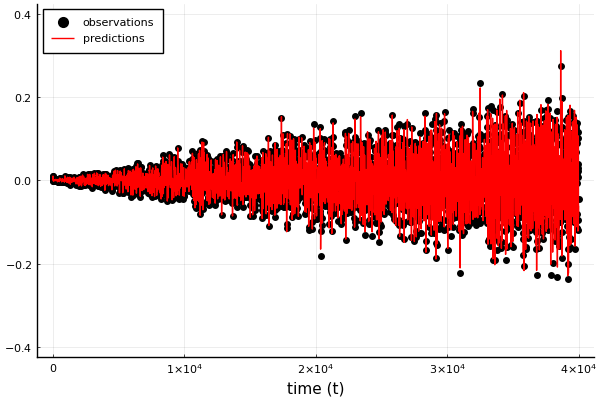

In [33]:
# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Plot predictions
p402 = scatter(viz_ix, output[viz_ix], label="observations", ylims=[-.4, .4], color="black")
plot!(viz_ix, results_NARX["pred_states"][viz_ix], label="predictions", xlabel="time (t)", color="red")

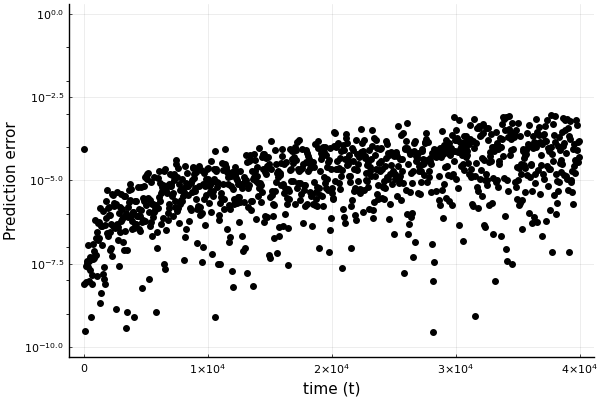

In [34]:
# Subsample for visualization
ss = 40
viz_ix = 1:ss:40000

# Scatter error over time
p403 = scatter(viz_ix, results_NARX["pred_error"][viz_ix], color="black", xlabel="time (t)", ylims=[1e-10, 1e0], ylabel="Prediction error", label="", yscale=:log10)

## Comparison

In [35]:
# Store prediction error for each step ahead
prederror_LARX = (results_LARX["preds"][1][1,2:end,K+1] .- output_val[3:end]).^2
prederror_NLARX = (results_NLARX["preds"][1][1,2:end,K+1] .- output_val[3:end]).^2
prederror_NARX = results_NARX["pred_error"]

println("MSE FEM-LARX = "*string(mean(prederror_LARX)))
println("MSE FEM-NLARX = "*string(mean(prederror_NLARX)))
println("MSE PEM-NARX = "*string(mean(prederror_NARX)))

MSE FEM-LARX = 5.9446129987526364e-5
MSE FEM-NLARX = 5.8304968780121563e-5
MSE PEM-NARX = 5.830793034083989e-5


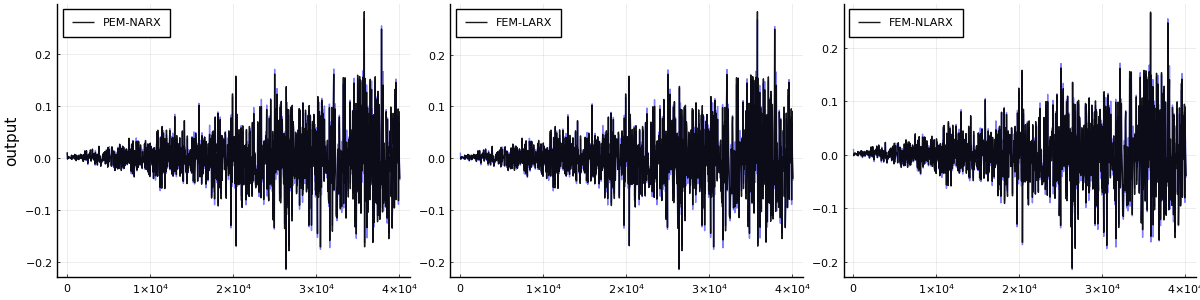

In [36]:
# Joint plot of prediction errors

# Subsample for visualization
ss = 40
viz_ix = 3:ss:T_val

# Scatter error over time
p71 = plot(viz_ix, output[viz_ix], label="", color="blue", alpha=0.5, ylims=[-0.2 0.2])
plot!(viz_ix, results_NLARX["preds"][1][1,viz_ix.-1,K+1], color="black", alpha=0.9, xlabel="", ylabel="", label="FEM-NLARX", legend=:topleft)
p72 = plot(viz_ix, output[viz_ix], label="", color="blue", alpha=0.5, ylims=[-0.2 0.2])
plot!(viz_ix, results_LARX["preds"][1][1,viz_ix.-1,K+1], color="black", alpha=0.9, xlabel="", ylabel="", label="FEM-LARX", legend=:topleft)
p73 = plot(viz_ix, output[viz_ix], label="", color="blue", alpha=0.5, ylims=[-0.2 0.2])
plot!(viz_ix, results_NARX["pred_states"][viz_ix], color="black", alpha=0.9, xlabel="", ylabel="output", label="PEM-NARX", legend=:topleft)
p70 = plot(p73, p72, p71, layout=(1,3), size=(1200,300))

In [37]:
Plots.savefig(p70, "figures/pred-states-comparison.png")

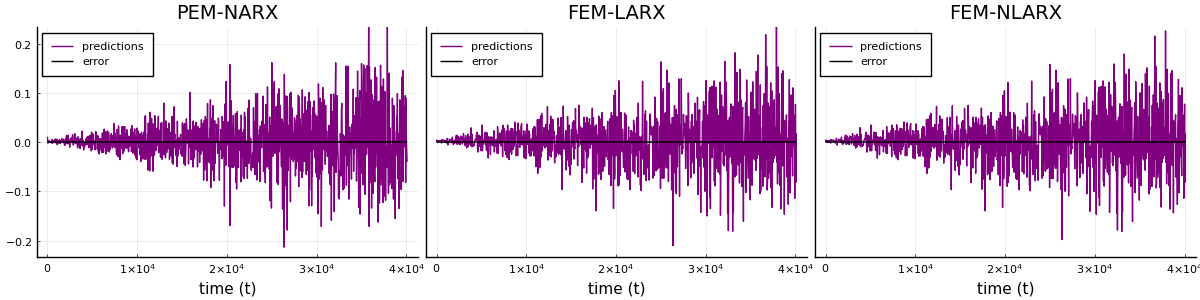

In [38]:
# Joint plot of prediction errors

# Subsample for visualization
ss = 40
viz_ix = 3:ss:T_val

# Scatter error over time
p81 = plot(viz_ix, results_NLARX["preds"][1][1,viz_ix,K+1], ylims=[-0.22, .22], color="purple", alpha=1.0, xlabel="", ylabel="", label="predictions", title="FEM-NLARX", legend=:topleft)
plot!(viz_ix, prederror_NLARX[viz_ix], color="black", alpha=1.0, xlabel="time (t)", ylabel="", label="error", yticks=:none)
p82 = plot(viz_ix, results_LARX["preds"][1][1,viz_ix,K+1], ylims=[-0.22, .22], color="purple", alpha=1.0, xlabel="", label="predictions", title="FEM-LARX", legend=:topleft)
plot!(viz_ix, prederror_LARX[viz_ix], color="black", alpha=1.0, xlabel="time (t)", ylabel="", label="error", yticks=:none)
p83 = plot(viz_ix, results_NARX["pred_states"][viz_ix], ylims=[-0.22, .22], color="purple", alpha=1.0, xlabel="", ylabel="", label="predictions", title="PEM-NARX", legend=:topleft)
plot!(viz_ix, prederror_NARX[viz_ix], color="black", alpha=1.0, xlabel="time (t)", ylabel="", label="error")
p80 = plot(p83, p82, p81, layout=(1,3), size=(1200,300))

In [39]:
savefig(p80, "figures/ksteppred-comparison.png")

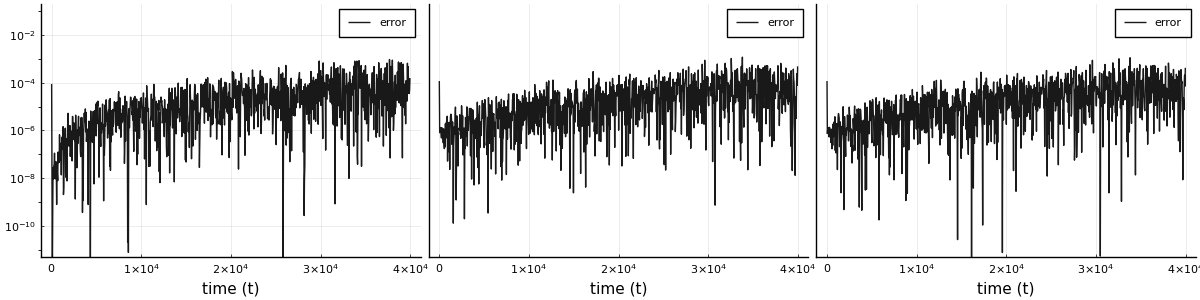

In [40]:
# Joint plot of prediction errors

# Subsample for visualization
ss = 40
viz_ix = 1:ss:40000

# Scatter error over time
p61 = plot(viz_ix, prederror_NLARX[viz_ix], color="black", alpha=0.9, xlabel="time (t)", title="", ylabel="", label="error", yticks=:none, ylims=[10e-12, 10e-2], yscale=:log10)
p62 = plot(viz_ix, prederror_LARX[viz_ix], color="black", alpha=0.9, xlabel="time (t)", title="", ylabel="", label="error", yticks=:none, ylims=[10e-12, 10e-2], yscale=:log10)
p63 = plot(viz_ix, prederror_NARX[viz_ix], color="black", alpha=0.9, xlabel="time (t)", title="", ylabel="", label="error", ylims=[10e-12, 10e-2], yscale=:log10)
p60 = plot(p63, p62, p61, layout=(1,3), size=(1200,300))

In [41]:
Plots.savefig(p60, "figures/pred-error-comparison.png")